<a href="https://colab.research.google.com/github/Amogh-Umesh/Facial-Recognition-with-siamese-networks/blob/main/Image_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
data_old = np.load('/content/drive/My Drive/olivetti_faces.npy')
print(data_old)

In [4]:
import random
randomlist = []
x = True
count = 0
a = 10
for b in range(1,41):
    a = b*10
    x = True
    while x:
        n = random.randint(a-10, a-1)
        if n not in randomlist:
            randomlist.append(n)
            count += 1
            if count == 5:
                count = 0
                x = False
print(randomlist)

[5, 9, 1, 0, 8, 16, 17, 15, 14, 12, 24, 20, 28, 21, 27, 39, 38, 33, 35, 34, 42, 40, 46, 44, 45, 52, 59, 56, 54, 53, 65, 63, 62, 66, 60, 72, 75, 71, 77, 76, 80, 85, 82, 88, 86, 99, 94, 97, 90, 98, 101, 100, 109, 102, 103, 113, 118, 110, 112, 116, 127, 121, 125, 124, 122, 130, 135, 133, 136, 131, 149, 140, 145, 141, 142, 159, 155, 157, 156, 152, 160, 169, 162, 161, 165, 174, 172, 173, 175, 171, 184, 188, 183, 181, 180, 193, 191, 196, 198, 194, 207, 206, 202, 209, 203, 212, 211, 219, 216, 217, 221, 228, 225, 224, 220, 231, 236, 234, 238, 230, 244, 249, 242, 248, 245, 257, 258, 255, 252, 253, 266, 267, 261, 262, 264, 274, 273, 270, 279, 276, 284, 280, 282, 283, 288, 296, 295, 293, 291, 290, 306, 308, 304, 305, 301, 319, 312, 318, 311, 313, 327, 321, 322, 323, 329, 331, 336, 332, 339, 337, 345, 346, 347, 348, 344, 357, 359, 352, 358, 355, 369, 366, 365, 362, 367, 376, 374, 372, 379, 371, 382, 385, 380, 384, 389, 393, 398, 392, 396, 395]


In [5]:
data = []
for i in randomlist:
  data.append(data_old[i])
print('done')

done


In [6]:
anchor_old = []
positive_old = []
negative_old = []
for person in range(1, 41):
  img_range = person * 5
  for anc in range(img_range-5, img_range):    
    for pos in range(img_range-5, img_range):
      if pos != anc:
        for neg in range(0, 200):
          if neg >= img_range or neg < (img_range - 5):
            anchor_old.append(anc)
            positive_old.append(pos)
            negative_old.append(neg)
print('{} {} {}'.format(len(anchor_old), len(positive_old), len(negative_old)))

156000 156000 156000


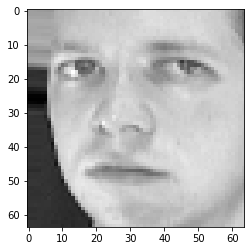

In [7]:
from matplotlib import pyplot as plt
b = data[0]
plt.imshow(b, cmap='gray')
plt.show()

In [8]:
def get_random_list():
  temp_arr = [i for i in range(0,156000)]
  np.random.shuffle(temp_arr)
  return temp_arr

print(len(get_random_list()))

156000


In [9]:
def shuffler():
  temp_arr = get_random_list()
  anchor = []
  positive = []
  negative = []
  for j in range(0,156000):
    anchor.append(anchor_old[temp_arr[j]])
    positive.append(positive_old[temp_arr[j]])
    negative.append(negative_old[temp_arr[j]])
  return ([anchor, positive, negative])

In [10]:
counter = 0
shuffled_data = shuffler()
def create_batch():
  global counter, shuffled_data  
  batch_size=64
  counter+=1
  if counter == 2438:
    shuffled_data = shuffler()
    counter = counter%2438
  anchor = shuffled_data[0]
  positive = shuffled_data[1]
  negative = shuffled_data[2]
  ind = counter*batch_size
  if counter < 2437:
    batch = [np.array([data[j] for j in anchor[ind:ind+64]]), np.array([data[j] for j in positive[ind:ind+64]]), np.array([data[j] for j in negative[ind:ind+64]])]
  elif counter == 2437:
    batch = [np.array([data[j] for j in anchor[ind:]]), np.array([data[j] for j in positive[ind:]]), np.array([data[j] for j in negative[ind:]])]
  return(batch)

def data_generator():
  global shuffled_data
  shuffled_data = shuffler()
  while True:
      x = create_batch()
      y = np.zeros((64, 3*128))
      yield x,y

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
import tensorflow as tf

In [12]:
def cnn_net():
  model = Sequential()
  model.add(Convolution2D(32, kernel_size = (4,4), activation = 'relu', input_shape=(64,64,1)))
  model.add(MaxPooling2D(pool_size=(2,2), strides = 2))
  model.add(Convolution2D(32, kernel_size = (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides = 2))  
  model.add(Convolution2D(16, kernel_size = (2,2), activation='relu'))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))  
  model.add(Dense(128, activation='sigmoid'))
  return model

In [13]:
feature_extractor = cnn_net()

In [14]:
input_anchor = tf.keras.layers.Input(shape=(64,64,1))
input_positive = tf.keras.layers.Input(shape=(64,64,1))
input_negative = tf.keras.layers.Input(shape=(64,64,1))
embedding_anchor = feature_extractor(input_anchor)
embedding_positive = feature_extractor(input_positive)
embedding_negative = feature_extractor(input_negative)
output = [embedding_anchor, embedding_positive, embedding_negative]
siamese_net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          193296      input_1[0][0]                    
                                                                 input_2[0][0]                

In [15]:
def triplet_loss(y_true, pred): 
    a = 0.2
    anc = pred[0]
    pos = pred[1]
    neg = pred[2]
    ap1 = tf.square(anc - pos)
    an1 = tf.square(anc - neg)    
    ap2 , an2 = [], []
    for x in range(64):
      ap2.append(tf.maximum(tf.reduce_sum(ap1[x]), 0.))
      an2.append(tf.maximum(tf.reduce_sum(an1[x]), 0.))    
    ap2 = tf.convert_to_tensor(ap2)
    an2 = tf.convert_to_tensor(an2)    
    AP = tf.reduce_sum(ap2)
    AN = tf.reduce_sum(an1)
    diff = (AP - AN)/10
    loss = tf.maximum(diff + a, 0.)
    return loss

In [16]:
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")        
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [17]:
opt = keras.optimizers.Adam(lr = 0.0001)
siamese_net.compile(loss=triplet_loss, optimizer= opt)

In [ ]:
print(siamese_net(create_batch())[0].shape)

In [23]:
print(triplet_loss(0, siamese_net(create_batch())))
print(counter)

tf.Tensor(0.19704613, shape=(), dtype=float32)
7


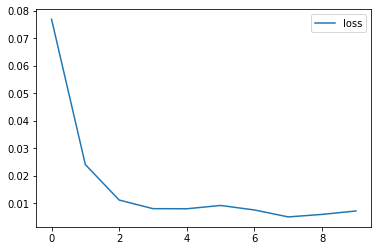

In [19]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=50, mode='auto', restore_best_weights=True)
reduce_on_plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=15, cooldown=5, verbose=0)

H = siamese_net.fit(data_generator(), epochs = 10, verbose = 1, callbacks = [early_stopping, plot_losses], steps_per_epoch=2437)

In [20]:
model_json = siamese_net.to_json()
with open("/content/drive/My Drive/siamese_net_best.json", "w") as json_file:
    json_file.write(model_json)
siamese_net.save_weights("/content/drive/My Drive/model_best.h5")
print("Saved model to drive")

Saved model to drive


In [28]:
def test_data():
  for a in range(0,300):
      x = create_batch()
      y = np.zeros((64, 3*128))
      yield x,y
score = siamese_net.evaluate(test_data(), verbose = 1)
print(score)
print("%s: %.2f%%" % (siamese_net.metrics_names[2], score[2]*100))

300/300 [==============================] - 11s 27ms/step - loss: 0.6000 - sequential_loss: 0.2000 - sequential_1_loss: 0.2000 - sequential_2_loss: 0.2000
[0.6000010371208191, 0.20000052452087402, 0.20000052452087402, 0.20000052452087402]
sequential_1_loss: 20.00%


In [29]:
def tester(anc, pos, neg):     
    AP = tf.reduce_mean(tf.square(anc - pos))
    AN = tf.reduce_mean(tf.square(anc - neg))
    return [AP, AN]
print(tester(feature_extractor([data[0].reshape(1,64,64,1)]), feature_extractor([data[1].reshape(1,64,64,1)]), feature_extractor([data[30].reshape(1,64,64,1)])))

[<tf.Tensor: shape=(), dtype=float32, numpy=2.2203744e-24>, <tf.Tensor: shape=(), dtype=float32, numpy=1.1164599e-24>]


In [ ]:
import time
time.sleep(10000)
print('f')